In [288]:
#Requirements
#!pip install torchdyn
#!pip install torchdiffeq
#!pip install POT
#!pip install tabulate


In [289]:
import torch
import os
import time
import shutil
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ot as pot
import torch.optim as optim
from tqdm import tqdm
from torchdiffeq import odeint_adjoint as odeint
from torchdyn.datasets import generate_gaussians, generate_moons, generate_spirals
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tabulate import tabulate

In [290]:
"""                        DATA FOLDER                    """

'                        DATA FOLDER                    '

In [291]:
#Toy data sampler

def sample_normal(n, mu=torch.zeros(2), sigma=1):
    distr = torch.distributions.MultivariateNormal(mu, sigma*torch.eye(2))
    return distr.sample((n,))

def sample_gaussians(n, n_gaussians=8, radius=4):
    num = int(n/n_gaussians)+1
    x0, _ = generate_gaussians(n_samples=num, n_gaussians=n_gaussians, radius=radius)
    return x0[:n]

def sample_moons(n):
    x0, _ = generate_moons(n, noise=0.2)
    return x0 * 3 - 1

def sample_spirals(n):
    x0, _ = generate_spirals(int(n/2) , dim=2, inner_radius=.5, outer_radius=1)
    return x0

class sampler():
    def __init__(self, dataset: str):
        if dataset == "normal":
            self.sampler = sample_normal
        elif dataset == "gaussians":
            self.sampler = sample_gaussians
        elif dataset == "moons":
            self.sampler = sample_moons
        elif dataset == "spirals":
            self.sampler = sample_spirals
        else:
            raise Exception("Selected Dataset not supported. Choose between normal, gaussians, moons or spirals")

    
    def __call__(self, n: int):
        return self.sampler(n)

In [292]:
#MNIST test/train loader

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [331]:
#UTILS 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#chooses appropriate timesteps for numerical ODE solver
def choose_timesteps(method: str):
    if method in ['euler', 'rk4', 'midpoint', 'explicit_adams', 'implicit_adams']:
        return torch.linspace(0, 1, 5).type(torch.float32)
    
    elif method in ['dopri8', 'dopri5', 'bosh3', 'adaptive_heun']:
        return torch.linspace(0, 1, 2).type(torch.float32)
    
    else:
        raise Exception("numerical method not supported")
    

#saves the train logs  
def save_train_logs(path, param, batch, loss, times):
    os.makedirs(path + "/logs", exist_ok=True)
    file_path = path + "/logs/train.txt"

    with open(file_path, "w") as file:

        file.write("Parameters:\n")
        for param, value in param.items():
            file.write(f"{param}: {value}\n")

        if "mnist" in path:
            headers = ["epoch", "loss", "time"]
        else:
            headers = ["batch", "loss", "time"]

        data = list(zip(batch, loss, times))
        file.write(tabulate(data, headers=headers, tablefmt='grid'))


#Computes trace Estimate and Frobenius norm of the Jacobian
def divergence_approx(f, y, e=None):

    samples = []
    sqnorms = []
    for  e_ in e:
        e_dzdx = torch.autograd.grad(f, y, e_, create_graph=True)[0]
        n = e_dzdx.view(y.size(0),-1).pow(2).mean(dim=1, keepdim=True)
        sqnorms.append(n)
        e_dzdx_e = e_dzdx * e_
        samples.append(e_dzdx_e.view(y.shape[0], -1).sum(dim=1, keepdim=True))

    S = torch.cat(samples, dim=1)
    approx_tr_dzdx = S.mean(dim=1)

    N = torch.cat(sqnorms, dim=1).mean(dim=1)


    return approx_tr_dzdx, N

In [294]:
"""                      MODELS FOLDER                    """

'                      MODELS FOLDER                    '

In [295]:
#Augmented ODE's

"""Augmented ODE for Toy dataset"""
class aug_toy(nn.Module):
    def __init__(self, ode_func: nn.Module, n_iter: int = 1):
        super().__init__()
        self.odefunc = ode_func
        self.n_iter = n_iter

    def forward(self, t, states):
        z = states[0].to(device)

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)                                        
            dz_dt = self.odefunc(t.to(device), z)
            epsilon = torch.randn(self.n_iter, *z.size()).to(device)
            dlog_det_dt, _ = divergence_approx(dz_dt, z, e=epsilon)                

            return (dz_dt, dlog_det_dt.unsqueeze(1))
            

"""Augmented ODE for MNIST"""
class aug_mnist(nn.Module):
    def __init__(self, ode_func: nn.Module, n_iter: int = 1):
        super().__init__()
        self.odefunc = ode_func
        self.n_iter = n_iter

    def forward(self, t, states):
        z = states[0].to(device)

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)                                         
            dz_dt = self.odefunc(t.to(device), z)
            epsilon = torch.randn(self.n_iter, *z.size()).to(device)
            dlog_det_dt, _ = divergence_approx(dz_dt, z, e=epsilon)

            
            return (dz_dt, dlog_det_dt.unsqueeze(1))
        

"""regularized Augmented ODE for Toy dataset"""
class reg_aug_toy(nn.Module):
    def __init__(self, ode_func: nn.Module):
        super().__init__()
        self.odefunc = ode_func

    def forward(self, t, states):
        z = states[0].to(device)

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)                                         
            dz_dt = self.odefunc(t.to(device), z)
            epsilon = torch.randn_like(z).to(device)
            dlog_det_dt, dn_dt = divergence_approx(dz_dt, z, e=epsilon.unsqueeze(0))
            dE_dt = (torch.linalg.vector_norm(dz_dt, dim=1, keepdims=True)**2)                          #log-det of the Jacobian   

            return (dz_dt, dlog_det_dt.unsqueeze(1), dE_dt, dn_dt.unsqueeze(1))


"""regularized Augmented ODE for MNIST"""
class reg_aug_mnist(nn.Module):
    def __init__(self, ode_func: nn.Module):
        super().__init__()
        self.odefunc = ode_func

    def forward(self, t, states):
        z = states[0].to(device)

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)                                         
            dz_dt = self.odefunc(t.to(device), z)
            epsilon = torch.randn_like(z).to(device)
            dlog_det_dt, dn_dt = divergence_approx(dz_dt, z, e=epsilon.unsqueeze(0))
            dE_dt = (torch.linalg.matrix_norm(dz_dt))**2
            
            return (dz_dt, dlog_det_dt.unsqueeze(1), dE_dt, dn_dt.unsqueeze(1))

In [296]:
#NODE WRAPPER CLASS and evaluation metrics

class NODE(nn.Module):
    def __init__(self, ode_func: nn.Module):
        super().__init__()
        self.odefunc = ode_func

    def forward(self, x, traj=False, t=torch.linspace(1, 0, 2).type(torch.float32)):
        flow = odeint(self.odefunc, x.to(device), t.to(device), 
                              method="dopri5",        
                              atol=1e-3,
                              rtol=1e-3,)
        
        if traj:
            return flow
        else:
            return flow[-1]
        
    def log_likelihood(self, x, n_iter=10, odeint_method="dopri5"):
        t = choose_timesteps(odeint_method).to(device)
        l0 = torch.zeros(x.size(0), 1).to(device)
        initial_values = (x.to(device), l0)

        if x.dim() == 2:
            normal = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))
            aug_dynamics = aug_toy(self.odefunc, n_iter)
        else:
            normal = torch.distributions.MultivariateNormal(torch.zeros(28).to(device), torch.eye(28).to(device))
            aug_dynamics = aug_mnist(self.odefunc, n_iter)

        with torch.no_grad():
            x_t, log_det_t = odeint(aug_dynamics, initial_values, t,
                                    method = odeint_method,
                                    atol=1e-3,
                                    rtol=1e-3,)
            logp_x = normal.log_prob(x_t[-1]) + log_det_t[-1]

            return logp_x.mean()

def flow_length(flow):
    diff = flow[1:] - flow[:-1]

    if diff.dim() == 3:
        dist = torch.linalg.norm(diff, dim=-1)
    else:
        dist = torch.linalg.norm(diff, dim=(-2,-1)).squeeze()

    return torch.mean(dist.sum(dim=0))

def wasserstein2(x, y):
    bs = x.size(0)
    a, b = pot.unif(bs), pot.unif(bs)

    if x.dim() > 2:
        x = x.reshape(bs, -1)
        y = y.reshape(bs, -1)
    
    M = torch.cdist(x, y)**2
    dist = pot.emd2(a, b, M.detach().cpu().numpy(), numItermax=int(1e7))

    return dist**.5

In [297]:
#UNET2 

#!/usr/bin/env python

# The file is copied and modified from 
# 
# C.-W. Huang, J. H. Lim, and A. Courville. 
# A variational perspective on diffusion-based generative models and score matching. 
# Advances in Neural Information Processing Systems, 2021
# 
# Code from https://github.com/CW-Huang/sdeflow-light

"""
Copied and modified from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/models/unet.py
Copied and modified from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py
"""
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
# noinspection PyProtectedMember
from torch.nn.init import _calculate_fan_in_and_fan_out


class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    # noinspection PyMethodMayBeStatic
    def forward(self, x):
        return torch.sigmoid(x) * x


def group_norm(out_ch):
    return nn.GroupNorm(num_groups=32, num_channels=out_ch, eps=1e-6, affine=True)


def upsample(in_ch, with_conv):
    up = nn.Sequential()
    up.add_module('up_nn', nn.Upsample(scale_factor=2, mode='nearest'))
    if with_conv:
        up.add_module('up_conv', conv2d(in_ch, in_ch, kernel_size=(3, 3), stride=1))
    return up


def downsample(in_ch, with_conv):
    if with_conv:
        down = conv2d(in_ch, in_ch, kernel_size=(3, 3), stride=2)
    else:
        down = nn.AvgPool2d(2, 2)
    return down


class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, conv_shortcut=False, dropout=0., normalize=group_norm, act=Swish()):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch if out_ch is not None else in_ch
        self.conv_shortcut = conv_shortcut
        self.dropout = dropout
        self.act = act

        self.norm1 = normalize(in_ch) if normalize is not None else nn.Identity()
        self.conv1 = conv2d(in_ch, out_ch)
        self.norm2 = normalize(out_ch) if normalize is not None else nn.Identity()
        self.dropout = nn.Dropout2d(p=dropout) if dropout > 0. else nn.Identity()
        self.conv2 = conv2d(out_ch, out_ch, init_scale=0.)
        if in_ch != out_ch:
            if conv_shortcut:
                self.shortcut = conv2d(in_ch, out_ch)
            else:
                self.shortcut = conv2d(in_ch, out_ch, kernel_size=(1, 1), padding=0)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        # forward conv1
        h = x
        h = self.act(self.norm1(h))
        h = self.conv1(h)

        # forward conv2
        h = self.act(self.norm2(h))
        h = self.dropout(h)
        h = self.conv2(h)

        # shortcut
        x = self.shortcut(x)

        # combine and return
        assert x.shape == h.shape
        return x + h


class SelfAttention(nn.Module):
    """
    copied modified from https://github.com/voletiv/self-attention-GAN-pytorch/blob/master/sagan_models.py#L29
    copied modified from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/models/unet.py#L66
    """

    def __init__(self, in_channels, normalize=group_norm):
        super().__init__()
        self.in_channels = in_channels
        self.attn_q = conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.attn_k = conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.attn_v = conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.proj_out = conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0, init_scale=0.)
        self.softmax = nn.Softmax(dim=-1)
        if normalize is not None:
            self.norm = normalize(in_channels)
        else:
            self.norm = nn.Identity()

    # noinspection PyUnusedLocal
    def forward(self, x):
        """ t is not used """
        _, C, H, W = x.size()

        h = self.norm(x)
        q = self.attn_q(h).view(-1, C, H * W)
        k = self.attn_k(h).view(-1, C, H * W)
        v = self.attn_v(h).view(-1, C, H * W)

        attn = torch.bmm(q.permute(0, 2, 1), k) * (int(C) ** (-0.5))
        attn = self.softmax(attn)

        h = torch.bmm(v, attn.permute(0, 2, 1))
        h = h.view(-1, C, H, W)
        h = self.proj_out(h)

        assert h.shape == x.shape
        return x + h


def _calculate_correct_fan(tensor, mode):
    """
    copied and modified from https://github.com/pytorch/pytorch/blob/master/torch/nn/init.py#L337
    """
    mode = mode.lower()
    valid_modes = ['fan_in', 'fan_out', 'fan_avg']
    if mode not in valid_modes:
        raise ValueError("Mode {} not supported, please use one of {}".format(mode, valid_modes))

    fan_in, fan_out = _calculate_fan_in_and_fan_out(tensor)
    return fan_in if mode == 'fan_in' else fan_out


def kaiming_uniform_(tensor, gain=1., mode='fan_in'):
    r"""Fills the input `Tensor` with values according to the method
    described in `Delving deep into rectifiers: Surpassing human-level
    performance on ImageNet classification` - He, K. et al. (2015), using a
    uniform distribution. The resulting tensor will have values sampled from
    :math:`\mathcal{U}(-\text{bound}, \text{bound})` where

    .. math::
        \text{bound} = \text{gain} \times \sqrt{\frac{3}{\text{fan\_mode}}}

    Also known as He initialization.

    Args:
        tensor: an n-dimensional `torch.Tensor`
        gain: multiplier to the dispersion
        mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
            preserves the magnitude of the variance of the weights in the
            forward pass. Choosing ``'fan_out'`` preserves the magnitudes in the
            backwards pass.
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.kaiming_uniform_(w, mode='fan_in')
    """
    fan = _calculate_correct_fan(tensor, mode)
    # gain = calculate_gain(nonlinearity, a)
    var = gain / max(1., fan)
    bound = math.sqrt(3.0 * var)  # Calculate uniform bounds from standard deviation
    with torch.no_grad():
        return tensor.uniform_(-bound, bound)


def variance_scaling_init_(tensor, scale):
    return kaiming_uniform_(tensor, gain=1e-10 if scale == 0 else scale, mode='fan_avg')


def dense(in_channels, out_channels, init_scale=1.):
    lin = nn.Linear(in_channels, out_channels)
    variance_scaling_init_(lin.weight, scale=init_scale)
    nn.init.zeros_(lin.bias)
    return lin


def conv2d(in_planes, out_planes, kernel_size=(3, 3), stride=1, dilation=1, padding=1, bias=True, padding_mode='zeros',
           init_scale=1.):
    conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation,
                     bias=bias, padding_mode=padding_mode)
    variance_scaling_init_(conv.weight, scale=init_scale)
    if bias:
        nn.init.zeros_(conv.bias)
    return conv


def get_sinusoidal_positional_embedding(timesteps: torch.LongTensor, embedding_dim: int):
    """
    Copied and modified from
        https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/nn.py#L90

    From Fairseq in
        https://github.com/pytorch/fairseq/blob/master/fairseq/modules/sinusoidal_positional_embedding.py#L15
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert len(timesteps.size()) == 1
    timesteps = timesteps.to(torch.get_default_dtype())
    device = timesteps.device

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float, device=device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)  # bsz x embd
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1), "constant", 0)
    assert list(emb.size()) == [timesteps.size(0), embedding_dim]
    return emb


class UNet(nn.Module):
    def __init__(self,
                 input_channels=1,
                 input_height=28,
                 ch=32,
                 output_channels=None,
                 ch_mult=(1, 2, 4),
                 num_res_blocks=2,
                 attn_resolutions=(16,),
                 dropout=0.,
                 resamp_with_conv=True,
                 act=Swish(),
                 normalize=group_norm,
                 ):
        super().__init__()
        self.input_channels = input_channels
        self.input_height = input_height
        self.ch = ch
        self.output_channels = output_channels = input_channels if output_channels is None else output_channels
        self.ch_mult = ch_mult
        self.num_res_blocks = num_res_blocks
        self.attn_resolutions = attn_resolutions
        self.dropout = dropout
        self.resamp_with_conv = resamp_with_conv
        self.act = act
        self.normalize = normalize

        # init
        self.num_resolutions = num_resolutions = len(ch_mult)
        in_ht = input_height
        in_ch = input_channels
        assert in_ht % 2 ** (num_resolutions - 1) == 0, "input_height doesn't satisfy the condition"


        # Downsampling
        self.begin_conv = conv2d(in_ch, ch)
        unet_chs = [ch]
        in_ht = in_ht
        in_ch = ch
        down_modules = []
        for i_level in range(num_resolutions):
            # Residual blocks for this resolution
            block_modules = {}
            out_ch = ch * ch_mult[i_level]
            for i_block in range(num_res_blocks):
                block_modules['{}a_{}a_block'.format(i_level, i_block)] = \
                    ResidualBlock(
                        in_ch=in_ch,
                        out_ch=out_ch,
                        dropout=dropout,
                        act=act,
                        normalize=normalize,
                    )
                if in_ht in attn_resolutions:
                    block_modules['{}a_{}b_attn'.format(i_level, i_block)] = SelfAttention(out_ch, normalize=normalize)
                unet_chs += [out_ch]
                in_ch = out_ch
            # Downsample
            if i_level != num_resolutions - 1:
                block_modules['{}b_downsample'.format(i_level)] = downsample(out_ch, with_conv=resamp_with_conv)
                in_ht //= 2
                unet_chs += [out_ch]
            # convert list of modules to a module list, and append to a list
            down_modules += [nn.ModuleDict(block_modules)]
        # conver to a module list
        self.down_modules = nn.ModuleList(down_modules)

        # Middle
        mid_modules = []
        mid_modules += [
            ResidualBlock(in_ch, out_ch=in_ch, dropout=dropout, act=act, normalize=normalize)]
        mid_modules += [SelfAttention(in_ch, normalize=normalize)]
        mid_modules += [
            ResidualBlock(in_ch, out_ch=in_ch, dropout=dropout, act=act, normalize=normalize)]
        self.mid_modules = nn.ModuleList(mid_modules)

        # Upsampling
        up_modules = []
        for i_level in reversed(range(num_resolutions)):
            # Residual blocks for this resolution
            block_modules = {}
            out_ch = ch * ch_mult[i_level]
            for i_block in range(num_res_blocks + 1):
                block_modules['{}a_{}a_block'.format(i_level, i_block)] = \
                    ResidualBlock(
                        in_ch=in_ch + unet_chs.pop(),
                        out_ch=out_ch,
                        dropout=dropout,
                        act=act,
                        normalize=normalize)
                if in_ht in attn_resolutions:
                    block_modules['{}a_{}b_attn'.format(i_level, i_block)] = SelfAttention(out_ch, normalize=normalize)
                in_ch = out_ch
            # Upsample
            if i_level != 0:
                block_modules['{}b_upsample'.format(i_level)] = upsample(out_ch, with_conv=resamp_with_conv)
                in_ht *= 2
            # convert list of modules to a module list, and append to a list
            up_modules += [nn.ModuleDict(block_modules)]
        # conver to a module list
        self.up_modules = nn.ModuleList(up_modules)
        assert not unet_chs

        # End
        self.end_conv = nn.Sequential(
            normalize(in_ch),
            self.act,
            conv2d(in_ch, output_channels, init_scale=0.),
        )

    # noinspection PyMethodMayBeStatic
    def _compute_cond_module(self, module, x):
        for m in module:
            x = m(x)
        return x

    # noinspection PyArgumentList,PyShadowingNames
    def forward(self, t, x):
        del t
        # Init
        B, C, H, W = x.size()

        # Downsampling
        hs = [self.begin_conv(x)]
        for i_level in range(self.num_resolutions):
            # Residual blocks for this resolution
            block_modules = self.down_modules[i_level]
            for i_block in range(self.num_res_blocks):
                resnet_block = block_modules['{}a_{}a_block'.format(i_level, i_block)]
                h = resnet_block(hs[-1])
                if h.size(2) in self.attn_resolutions:
                    attn_block = block_modules['{}a_{}b_attn'.format(i_level, i_block)]
                    h = attn_block(h)
                hs.append(h)
            # Downsample
            if i_level != self.num_resolutions - 1:
                downsample = block_modules['{}b_downsample'.format(i_level)]
                hs.append(downsample(hs[-1]))

        # Middle
        h = hs[-1]
        h = self._compute_cond_module(self.mid_modules, h)

        # Upsampling
        for i_idx, i_level in enumerate(reversed(range(self.num_resolutions))):
            # Residual blocks for this resolution
            block_modules = self.up_modules[i_idx]
            for i_block in range(self.num_res_blocks + 1):
                resnet_block = block_modules['{}a_{}a_block'.format(i_level, i_block)]
                h = resnet_block(torch.cat([h, hs.pop()], axis=1))
                if h.size(2) in self.attn_resolutions:
                    attn_block = block_modules['{}a_{}b_attn'.format(i_level, i_block)]
                    h = attn_block(h)
            # Upsample
            if i_level != 0:
                upsample = block_modules['{}b_upsample'.format(i_level)]
                h = upsample(h)
        assert not hs

        # End
        h = self.end_conv(h)
        assert list(h.size()) == [x.size(0), self.output_channels, x.size(2), x.size(3)]
        return h


if __name__ == '__main__':

    model = UNet()
    
    model(1, torch.randn((1,1,28,28)))
   

In [298]:
#MLP

class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=None, hidden_dim=256):
        super().__init__()
        if out_dim is None:
            out_dim = in_dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_dim + 1, hidden_dim),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, t, x):
        if t.dim()==0:
            t = t.expand(x.size(0),)
        x = torch.cat((x, t[:,None]),dim=-1) 
        return self.net(x)

In [299]:
"""                    Training Folder                    """

'                    Training Folder                    '

In [300]:
#UTILS    
    
def save_train_logs(path, param, batch, loss, times):
    os.makedirs(path + "/logs", exist_ok=True)
    file_path = path + "/logs/train.txt"

    with open(file_path, "w") as file:

        file.write("Parameters:\n")
        for param, value in param.items():
            file.write(f"{param}: {value}\n")

        if "mnist" in path:
            headers = ["epoch", "loss", "time"]
        else:
            headers = ["batch", "loss", "time"]

        data = list(zip(batch, loss, times))
        file.write(tabulate(data, headers=headers, tablefmt='grid'))

In [301]:
#Optimal Transport Sampler

"""From https://github.com/atong01/conditional-flow-matching/blob/main/torchcfm/optimal_transport.py"""
import warnings
from functools import partial


class OTPlanSampler:
    """OTPlanSampler implements sampling coordinates according to an OT plan (wrt squared Euclidean
    cost) with different implementations of the plan calculation."""

    def __init__(
        self,
        method: str,
        reg: float = 0.05,
        reg_m: float = 1.0,
        normalize_cost: bool = False,
        warn: bool = True,
    ) -> None:
        """Initialize the OTPlanSampler class.

        Parameters
        ----------
        method: str
            choose which optimal transport solver you would like to use.
            Currently supported are ["exact", "sinkhorn", "unbalanced",
            "partial"] OT solvers.
        reg: float, optional
            regularization parameter to use for Sinkhorn-based iterative solvers.
        reg_m: float, optional
            regularization weight for unbalanced Sinkhorn-knopp solver.
        normalize_cost: bool, optional
            normalizes the cost matrix so that the maximum cost is 1. Helps
            stabilize Sinkhorn-based solvers. Should not be used in the vast
            majority of cases.
        warn: bool, optional
            if True, raises a warning if the algorithm does not converge
        """
        # ot_fn should take (a, b, M) as arguments where a, b are marginals and
        # M is a cost matrix
        if method == "exact":
            self.ot_fn = pot.emd
        elif method == "sinkhorn":
            self.ot_fn = partial(pot.sinkhorn, reg=reg)
        elif method == "unbalanced":
            self.ot_fn = partial(pot.unbalanced.sinkhorn_knopp_unbalanced, reg=reg, reg_m=reg_m)
        elif method == "partial":
            self.ot_fn = partial(pot.partial.entropic_partial_wasserstein, reg=reg)
        else:
            raise ValueError(f"Unknown method: {method}")
        self.reg = reg
        self.reg_m = reg_m
        self.normalize_cost = normalize_cost
        self.warn = warn

    def get_map(self, x0, x1):
        """Compute the OT plan (wrt squared Euclidean cost) between a source and a target
        minibatch.

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the source minibatch

        Returns
        -------
        p : numpy array, shape (bs, bs)
            represents the OT plan between minibatches
        """
        a, b = pot.unif(x0.shape[0]), pot.unif(x1.shape[0])
        if x0.dim() > 2:
            x0 = x0.reshape(x0.shape[0], -1)
        if x1.dim() > 2:
            x1 = x1.reshape(x1.shape[0], -1)
        x1 = x1.reshape(x1.shape[0], -1)
        M = torch.cdist(x0, x1) ** 2
        if self.normalize_cost:
            M = M / M.max()  # should not be normalized when using minibatches
        p = self.ot_fn(a, b, M.detach().cpu().numpy())
        if not np.all(np.isfinite(p)):
            print("ERROR: p is not finite")
            print(p)
            print("Cost mean, max", M.mean(), M.max())
            print(x0, x1)
        if np.abs(p.sum()) < 1e-8:
            if self.warn:
                warnings.warn("Numerical errors in OT plan, reverting to uniform plan.")
            p = np.ones_like(p) / p.size
        return p

    def sample_map(self, pi, batch_size, replace=True):
        r"""Draw source and target samples from pi  $(x,z) \sim \pi$

        Parameters
        ----------
        pi : numpy array, shape (bs, bs)
            represents the source minibatch
        batch_size : int
            represents the OT plan between minibatches
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        (i_s, i_j) : tuple of numpy arrays, shape (bs, bs)
            represents the indices of source and target data samples from $\pi$
        """
        p = pi.flatten()
        p = p / p.sum()
        choices = np.random.choice(
            pi.shape[0] * pi.shape[1], p=p, size=batch_size, replace=replace
        )
        return np.divmod(choices, pi.shape[1])

    def sample_plan(self, x0, x1, replace=True):
        r"""Compute the OT plan $\pi$ (wrt squared Euclidean cost) between a source and a target
        minibatch and draw source and target samples from pi $(x,z) \sim \pi$

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the source minibatch
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        x0[i] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        x1[j] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        """
        pi = self.get_map(x0, x1)
        i, j = self.sample_map(pi, x0.shape[0], replace=replace)
        return x0[i], x1[j]

    def sample_plan_with_labels(self, x0, x1, y0=None, y1=None, replace=True):
        r"""Compute the OT plan $\pi$ (wrt squared Euclidean cost) between a source and a target
        minibatch and draw source and target labeled samples from pi $(x,z) \sim \pi$

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        y0 : Tensor, shape (bs)
            represents the source label minibatch
        y1 : Tensor, shape (bs)
            represents the target label minibatch
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        x0[i] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        x1[j] : Tensor, shape (bs, *dim)
            represents the target minibatch drawn from $\pi$
        y0[i] : Tensor, shape (bs, *dim)
            represents the source label minibatch drawn from $\pi$
        y1[j] : Tensor, shape (bs, *dim)
            represents the target label minibatch drawn from $\pi$
        """
        pi = self.get_map(x0, x1)
        i, j = self.sample_map(pi, x0.shape[0], replace=replace)
        return (
            x0[i],
            x1[j],
            y0[i] if y0 is not None else None,
            y1[j] if y1 is not None else None,
        )

    def sample_trajectory(self, X):
        """Compute the OT flow between different sample populations moving from the source
        to the target distribution.

        Parameters
        ----------
        X : Tensor, (bs, times, *dim)
            different populations of samples moving from the source to the target distribution.

        Returns
        -------
        to_return : Tensor, (bs, times, *dim)
            represents the OT sampled trajectories over time.
        """
        times = X.shape[1]
        pis = []
        for t in range(times - 1):
            pis.append(self.get_map(X[:, t], X[:, t + 1]))

        indices = [np.arange(X.shape[0])]
        for pi in pis:
            j = []
            for i in indices[-1]:
                j.append(np.random.choice(pi.shape[1], p=pi[i] / pi[i].sum()))
            indices.append(np.array(j))

        to_return = []
        for t in range(times):
            to_return.append(X[:, t][indices[t]])
        to_return = np.stack(to_return, axis=1)
        return to_return

"""Implements Conditional Flow Matcher Losses. From https://github.com/atong01/conditional-flow-matching/blob/main/torchcfm/conditional_flow_matching.py"""

# Author: Alex Tong
#         Kilian Fatras
#         +++
# License: MIT License

import warnings
from typing import Union


def pad_t_like_x(t, x):
    """Function to reshape the time vector t by the number of dimensions of x.

    Parameters
    ----------
    x : Tensor, shape (bs, *dim)
        represents the source minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    t : Tensor, shape (bs, number of x dimensions)

    Example
    -------
    x: Tensor (bs, C, W, H)
    t: Vector (bs)
    pad_t_like_x(t, x): Tensor (bs, 1, 1, 1)
    """
    if isinstance(t, (float, int)):
        return t
    return t.reshape(-1, *([1] * (x.dim() - 1)))


class ConditionalFlowMatcher:
    """Base class for conditional flow matching methods. This class implements the independent
    conditional flow matching methods from [1] and serves as a parent class for all other flow
    matching methods.

    It implements:
    - Drawing data from gaussian probability path N(t * x1 + (1 - t) * x0, sigma) function
    - conditional flow matching ut(x1|x0) = x1 - x0
    - score function $\nabla log p_t(x|x0, x1)$
    """

    def __init__(self, sigma: Union[float, int] = 0.0):
        r"""Initialize the ConditionalFlowMatcher class. It requires the hyper-parameter $\sigma$.

        Parameters
        ----------
        sigma : Union[float, int]
        """
        self.sigma = sigma

    def compute_mu_t(self, x0, x1, t):
        """
        Compute the mean of the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)

        Returns
        -------
        mean mu_t: t * x1 + (1 - t) * x0

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        t = pad_t_like_x(t, x0)
        return t * x1 + (1 - t) * x0

    def compute_sigma_t(self, t):
        """
        Compute the standard deviation of the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        t : FloatTensor, shape (bs)

        Returns
        -------
        standard deviation sigma

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        del t
        return self.sigma

    def sample_xt(self, x0, x1, t, epsilon):
        """
        Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)
        epsilon : Tensor, shape (bs, *dim)
            noise sample from N(0, 1)

        Returns
        -------
        xt : Tensor, shape (bs, *dim)

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        mu_t = self.compute_mu_t(x0, x1, t)
        sigma_t = self.compute_sigma_t(t)
        sigma_t = pad_t_like_x(sigma_t, x0)
        return mu_t + sigma_t * epsilon

    def compute_conditional_flow(self, x0, x1, t, xt):
        """
        Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt

        Returns
        -------
        ut : conditional vector field ut(x1|x0) = x1 - x0

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        del t, xt
        return x1 - x0

    def sample_noise_like(self, x):
        return torch.randn_like(x)

    def sample_location_and_conditional_flow(self, x0, x1, t=None, return_noise=False):
        """
        Compute the sample xt (drawn from N(t * x1 + (1 - t) * x0, sigma))
        and the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        (optionally) t : Tensor, shape (bs)
            represents the time levels
            if None, drawn from uniform [0,1]
        return_noise : bool
            return the noise sample epsilon


        Returns
        -------
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt
        ut : conditional vector field ut(x1|x0) = x1 - x0
        (optionally) eps: Tensor, shape (bs, *dim) such that xt = mu_t + sigma_t * epsilon

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        if t is None:
            t = torch.rand(x0.shape[0]).type_as(x0)
        assert len(t) == x0.shape[0], "t has to have batch size dimension"

        eps = self.sample_noise_like(x0)
        xt = self.sample_xt(x0, x1, t, eps)
        ut = self.compute_conditional_flow(x0, x1, t, xt)
        if return_noise:
            return t, xt, ut, eps
        else:
            return t, xt, ut

    def compute_lambda(self, t):
        """Compute the lambda function, see Eq.(23) [3].

        Parameters
        ----------
        t : FloatTensor, shape (bs)

        Returns
        -------
        lambda : score weighting function

        References
        ----------
        [4] Simulation-free Schrodinger bridges via score and flow matching, Preprint, Tong et al.
        """
        sigma_t = self.compute_sigma_t(t)
        return 2 * sigma_t / (self.sigma**2 + 1e-8)


class ExactOptimalTransportConditionalFlowMatcher(ConditionalFlowMatcher):
    """Child class for optimal transport conditional flow matching method. This class implements
    the OT-CFM methods from [1] and inherits the ConditionalFlowMatcher parent class.

    It overrides the sample_location_and_conditional_flow.
    """

    def __init__(self, sigma: Union[float, int] = 0.0):
        r"""Initialize the ConditionalFlowMatcher class. It requires the hyper-parameter $\sigma$.

        Parameters
        ----------
        sigma : Union[float, int]
        ot_sampler: exact OT method to draw couplings (x0, x1) (see Eq.(17) [1]).
        """
        super().__init__(sigma)
        self.ot_sampler = OTPlanSampler(method="exact")

    def sample_location_and_conditional_flow(self, x0, x1, t=None, return_noise=False):
        r"""
        Compute the sample xt (drawn from N(t * x1 + (1 - t) * x0, sigma))
        and the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1]
        with respect to the minibatch OT plan $\Pi$.

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        (optionally) t : Tensor, shape (bs)
            represents the time levels
            if None, drawn from uniform [0,1]
        return_noise : bool
            return the noise sample epsilon

        Returns
        -------
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt
        ut : conditional vector field ut(x1|x0) = x1 - x0
        (optionally) epsilon : Tensor, shape (bs, *dim) such that xt = mu_t + sigma_t * epsilon

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        x0, x1 = self.ot_sampler.sample_plan(x0, x1)
        return super().sample_location_and_conditional_flow(x0, x1, t, return_noise)



In [302]:
def train_toy_node(n_batches, batch_size, target='moons', learning_rate=1e-3, seed=22, odeint_method='dopri5'):

    torch.manual_seed(seed)
    np.random.seed(seed)
    model = MLP().to(device)

    target_distr = sampler(target)
    initial_distr = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    batch_save = int(n_batches/100)
    batch_loss = 0
    start = time.time()
    path = target + "/node"
    os.makedirs(path + "/models", exist_ok=True)

    batches, losses, train_time = [], [], []

    for i in tqdm(range(1, n_batches+1), desc="Training Batches"):
        optimizer.zero_grad()
        
        x = target_distr(batch_size).to(device)
        x.requires_grad = True

        t = choose_timesteps(odeint_method).to(device)
        l0 = torch.zeros((x.size(0),1), requires_grad=True).to(device)
        initial_values = (x, l0)

        augmented_dynamics = aug_toy(model)

        z_t, log_det = odeint(augmented_dynamics, initial_values, t,
                                        method=odeint_method,        
                                        atol=1e-3,
                                        rtol=1e-3,)


        z1, l1 = z_t[-1], log_det[-1]

        logp_x = initial_distr.log_prob(z1) + l1
        loss = -logp_x.mean()

        loss.backward()
        optimizer.step()

        batch_loss += loss

        if i%batch_save == 0:
            batch_loss = batch_loss/batch_save
            elapsed_time = time.time() - start
            
            batches.append(i)
            losses.append(batch_loss)
            train_time.append(elapsed_time)

            torch.save(model.state_dict(), os.path.join(path + "/models", f"{i}_model.pt"))
            #print(f"\nbatch {i}, Loss: {batch_loss}\n")
        
            if batch_loss > 1e+25:
                print(f"\n training collapsed at batch {i}")
                break

            batch_loss = 0

    print("finished training\n")

    return path, batches, losses, train_time

In [303]:
def train_toy_rnode(n_batches, batch_size, target='moons', learning_rate=1e-3, seed=22, lambda_k=.1, lambda_j=.1, odeint_method='dopri5'):

    torch.manual_seed(seed)
    np.random.seed(seed)
    model = MLP().to(device)

    target_distr = sampler(target)
    initial_distr = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    batch_save = int(n_batches/100)
    batch_loss = 0
    start = time.time()
    path = target + "/rnode"
    os.makedirs(path + "/models", exist_ok=True)

    batches, losses, train_time = [], [], []

    for i in tqdm(range(1, n_batches+1), desc="Training Batches"):
        optimizer.zero_grad()
        
        x = target_distr(batch_size).to(device)
        x.requires_grad = True

        t = choose_timesteps(odeint_method).to(device)
        l0 = torch.zeros((x.size(0),1), requires_grad=True).to(device)
        kin_E0 = torch.zeros((x.size(0),1), requires_grad=True).to(device)
        n0 = torch.zeros((x.size(0),1), requires_grad=True).to(device)
        initial_values = (x, l0, kin_E0, n0)

        augmented_dynamics = reg_aug_toy(model)

        z_t, log_det, E_t, n_t = odeint(augmented_dynamics, initial_values, t,
                                        method=odeint_method,        
                                        atol=1e-3,
                                        rtol=1e-3,)


        z1, l1, kin_E1, n1 = z_t[-1], log_det[-1], E_t[-1], n_t[-1]

        logp_x = initial_distr.log_prob(z1) + l1 - lambda_k * kin_E1 - lambda_j * n1
        loss = -logp_x.mean()

        loss.backward()
        optimizer.step()

        batch_loss += loss

        if i%batch_save == 0:
            batch_loss = batch_loss/batch_save
            elapsed_time = time.time() - start
            
            batches.append(i)
            losses.append(batch_loss)
            train_time.append(elapsed_time)

            torch.save(model.state_dict(), os.path.join(path + "/models", f"{i}_model.pt"))
            #print(f"\nbatch {i}, Loss: {batch_loss}\n")
            batch_loss = 0

    print("finished training\n")

    return path, batches, losses, train_time

In [304]:
def train_toy_cfm(n_batches, batch_size, target='moons', learning_rate=1e-3, seed=22, sigma=0):

    torch.manual_seed(seed)
    np.random.seed(seed)
    model = MLP().to(device)

    target_distr = sampler(target)
    initial_distr = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
    model.train()

    batch_save = int(n_batches/100)
    batch_loss = 0
    start = time.time()
    path = target + "/cfm"
    os.makedirs(path + "/models", exist_ok=True)

    batches, losses, train_time = [], [], []

    for i in tqdm(range(1, n_batches+1), desc="Training Batches"):
        optimizer.zero_grad()

        x0, x1 = initial_distr.sample((batch_size,)).to(device), target_distr(batch_size).to(device)
        t, xt, ut = FM.sample_location_and_conditional_flow(x1, x0)
        
        loss = torch.mean((model(t,xt) - ut)**2)
        loss.backward()
        optimizer.step()

        batch_loss += loss

        if i%batch_save == 0:
            batch_loss = batch_loss/batch_save
            elapsed_time = time.time() - start
            
            batches.append(i)
            losses.append(batch_loss)
            train_time.append(elapsed_time)

            torch.save(model.state_dict(), os.path.join(path + "/models", f"{i}_model.pt"))
            #print(f"\nbatch {i}, Loss: {batch_loss}\n")
            batch_loss = 0

    print("finished training\n")

    return path, batches, losses, train_time

In [305]:
def train_mnist_node(n_epochs, learning_rate=1e-3, seed=22, odeint_method='dopri5'):
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = UNet().to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    initial_distr = torch.distributions.MultivariateNormal(torch.zeros(28).to(device), torch.eye(28).to(device))
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    path = "mnist/node"
    os.makedirs(path + "/models", exist_ok=True)
    epochs, losses, train_time = [], [], []
    start = time.time()

    model.train()

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{n_epochs}')
        num = 0
        for i, (samples, labels) in progress_bar:
            optimizer.zero_grad()
            #samples.requires_grad = True

            x0 = samples.to(device)
            
            t = choose_timesteps(odeint_method).to(device)
            l0 = torch.zeros((x0.size(0),1), requires_grad=True).to(device)
            initial_values = (x0, l0)

            augmented_dynamics = aug_mnist(model)

            z_t, log_det = odeint(augmented_dynamics, initial_values, t, 
                                            method=odeint_method, 
                                            rtol=1e-5, 
                                            atol=1e-5,)
            
            z1, l1 = z_t[-1], log_det[-1]

            logp_x = initial_distr.log_prob(z1) + l1
            loss = -logp_x.mean()
            print(f'\n batch {i}, loss: {loss}')

            loss.backward()
            optimizer.step()

            epoch_loss += loss
            num += 1
        
        torch.save(model.state_dict(), os.path.join(path + "/models", f"{epoch}_model.pt"))
        print(f"\nloss: {epoch_loss/num}\n")
        
        elapsed_time = time.time() - start
        
        epochs.append(epoch)
        losses.append(epoch_loss/num)
        train_time.append(elapsed_time)
        
    print("finished training\n")

    return path, epochs, losses, train_time

In [306]:
def train_mnist_rnode(n_epochs, learning_rate=1e-3, seed=22, lambda_k=.1, lambda_j=.1, odeint_method='dopri5'):

    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = UNet().to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    initial_distr = torch.distributions.MultivariateNormal(torch.zeros(28).to(device), torch.eye(28).to(device))
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    path = "mnist/rnode"
    os.makedirs(path + "/models", exist_ok=True)
    epochs, losses, train_time = [], [], []
    start = time.time()

    model.train()

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{n_epochs}')
        num = 0
        for i, (samples, labels) in progress_bar:
            optimizer.zero_grad()
            #samples.requires_grad = True

            x0 = samples.to(device)
            
            t = choose_timesteps(odeint_method).to(device)
            l0 = torch.zeros((x0.size(0),1), requires_grad=True).to(device)
            kin_E0 = torch.zeros((x0.size(0),1), requires_grad=True).to(device)
            n0 = torch.zeros((x0.size(0),1), requires_grad=True).to(device)
            initial_values = (x0, l0, kin_E0, n0)

            augmented_dynamics = reg_aug_mnist(model)

            z_t, log_det, E_t, n_t = odeint(augmented_dynamics, initial_values, t, 
                                            method=odeint_method, 
                                            rtol=1e-5, 
                                            atol=1e-5,)

            z1, l1, kin_E1, n1 = z_t[-1], log_det[-1], E_t[-1], n_t[-1]

            logp_x = initial_distr.log_prob(z1) + l1 - lambda_k * kin_E1 - lambda_j * n1
            loss = -logp_x.mean()
            print(f'\n batch {i}, loss: {loss}')

            loss.backward()
            optimizer.step()

            epoch_loss += loss
            num += 1
        
        torch.save(model.state_dict(), os.path.join(path + "/models", f"{epoch}_model.pt"))
        print(f"\nloss: {epoch_loss/num}\n")
        
        elapsed_time = time.time() - start
        
        epochs.append(epoch)
        losses.append(epoch_loss/num)
        train_time.append(elapsed_time)
        
    print("finished training\n")

    return path, epochs, losses, train_time


In [307]:
def train_mnist_cfm(n_epochs, learning_rate=1e-3, seed=22, sigma=0):

    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = UNet().to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    path = "mnist/cfm"
    os.makedirs(path + "/models", exist_ok=True)
    epochs, losses, train_time = [], [], []
    start = time.time()

    model.train()

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{n_epochs}')
        num = 0
        for i, (samples, labels) in progress_bar:
            optimizer.zero_grad()

            x0 = torch.randn_like(samples).to(device)
            t, xt, ut = FM.sample_location_and_conditional_flow(samples.to(device), x0)
            vt = model(t, xt)
            loss = torch.mean((vt - ut) ** 2)
            loss.backward()
            optimizer.step()

            epoch_loss += loss
            num += 1
        
        torch.save(model.state_dict(), os.path.join(path + "/models", f"{epoch}_model.pt"))
        print(f"\nloss: {epoch_loss/num}\n")
        
        elapsed_time = time.time() - start
        
        epochs.append(epoch)
        losses.append(epoch_loss/num)
        train_time.append(elapsed_time)
        
    print("finished training\n")

    return path, epochs, losses, train_time

In [308]:
def train_model(dataset, training, 
                n_epochs = 1,       
                n_batches = 10,   
                batch_size = 10,
                odeint_method = 'rk4',
                lambda_k = .1,       
                lambda_j = .1,       
                sigma = 0.1,):         
    """ 
    Parameters for Training
        dataset: ['moons', 'gaussians', 'circles', 'mnist']
        training: ['node', 'rnode', 'cfm']

    MNIST datset parameters
        n_epochs: number of epochs for training    

    TOY dataset parameters
        n_batches: number of batches for training
        batch_size: size of training batches

    RNODE parameters
        odeint_method: ['euler', 'rk4', 'dopri5', 'dopri8']
        lambda_k: regularization constant for the kinetic energy
        lambda_j: regularization constant for the frobenius norm

    CFM parameters
        sigma: variance of gaussian probability paths
    """

    params = {
        "seed": 22,
        "learning_rate": 1e-3,
    }    

    if dataset == "mnist":
        params["n_epochs"] = n_epochs
        params["batch_size"] = 128

        if training == "node":
            params["odeint_method"] = odeint_method
            path, batch, loss, train_time = train_mnist_node(n_epochs, params["learning_rate"], params["seed"], odeint_method)

        elif training == "rnode":
            params["odeint_method"] = odeint_method
            params["lambda_k"] = lambda_k
            params["lambda_j"] = lambda_j
            
            path, batch, loss, train_time = train_mnist_rnode(n_epochs, params["learning_rate"], params["seed"], lambda_k, lambda_j, odeint_method)

        elif training == "cfm":
            params["sigma"] = sigma
            path, batch, loss, train_time = train_mnist_cfm(n_epochs, params["learning_rate"], params["seed"], sigma)
    else:
        params["n_batches"] = n_batches
        params["batch_size"] = batch_size

        if training == "node":
            params["odeint_method"] = odeint_method
            path, batch, loss, train_time = train_toy_node(n_batches, batch_size, dataset, params["learning_rate"], params["seed"], odeint_method)

        elif training == "rnode":
            params["odeint_method"] = odeint_method
            params["lambda_k"] = lambda_k
            params["lambda_j"] = lambda_j
            path, batch, loss, train_time = train_toy_rnode(n_batches, batch_size, dataset, params["learning_rate"], params["seed"], lambda_k, lambda_j, odeint_method)

        elif training == "cfm":
            params["sigma"] = sigma
            path, batch, loss, train_time = train_toy_cfm(n_batches, batch_size, dataset, params["learning_rate"], params["seed"], sigma)

    save_train_logs(path, params, batch, loss, train_time)


In [309]:
"""from ContNF import train_mnist_cfm
%mprun -f train_mnist_cfm train_mnist_cfm(5)"""

'from ContNF import train_mnist_cfm\n%mprun -f train_mnist_cfm train_mnist_cfm(5)'

In [310]:
"""                      Test Folder                      """

'                      Test Folder                      '

In [332]:
#UTILS

def setup_model_and_data(dataset: str, seed: int=10, toy_samples: int=2000):
    """
    for MNIST: returns batched samples from the normal distribution matching the test-loader
        

    for TOY: returns 2000 unsqueezed samples from both the normal and target distribution
        x[0], y[0][0] to access samples 2000x2
            
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    if dataset == "mnist":
        y = test_loader
        x = torch.randn((len(test_loader), 128, 1, 28, 28)).to(device)
        odefunc = UNet().to(device)
    else:
        y = sampler(dataset)(toy_samples)
        x = torch.randn_like(y).unsqueeze(0).to(device)
        y = [(y.to(device), 0)]
        odefunc = MLP().to(device)
    
    return x, y, odefunc

    
def evaluate_model(path, x, y, odefunc):
    odefunc.load_state_dict(torch.load(path, map_location=device))
    odefunc.eval()

    cont_NF = NODE(odefunc).to(device)
    c, neg_log, length, w2d = 0, 0, 0, 0

    for y_batched, _ in y:
        x_batched = x[c].to(device)
        y_batched = y_batched.to(device)
        c += 1

        flow = cont_NF(x_batched, traj=True, t=torch.linspace(1,0,10).to(device))
        neg_log += -cont_NF.log_likelihood(y_batched, 5)
        length += flow_length(flow)
        w2d += wasserstein2(flow[-1], y_batched)

    return neg_log/c, length/c, w2d/c


def save_test_logs(directory, training, name, neg_log, length, w2d):
    os.makedirs(directory, exist_ok=True)
    file_path = directory + '/test.txt'

    with open(file_path, "w") as file:

        if "mnist" in directory:
            file.write(f"{training} for MNIST dataset\n")
            headers = ["epoch", "negative log-likelihood", "flow length", "wasserstein2 distance"]
        else:
            file.write(f"{training} for TOY dataset\n")
            headers = ["batch", "negative log-likelihood", "flow length", "wasserstein2 distance"]
            
        data = list(zip(name, neg_log, length, w2d))
        file.write(tabulate(data, headers=headers, tablefmt='grid'))

def extract_batch_number(filename):
    return int(filename.split('_')[0])

In [312]:
def evaluate_models(directory: str):
    dataset, training, _ = directory.split('/')
    
    x, y, odefunc = setup_model_and_data(dataset)
    name, neg_log, length, w2d = [], [], [], []
    sorted_files = sorted(os.listdir(directory), key=extract_batch_number)

    i = 0
    total = len(sorted_files)

    for model in sorted_files:
        model_path = os.path.join(directory, model)
        a, b, c = evaluate_model(model_path, x, y, odefunc)
        name.append(model)
        neg_log.append(a)
        length.append(b)
        w2d.append(c)

        i += 1
        progress = (i) / total
        bar_length = 40
        block = int(round(bar_length * progress))
        progress_bar = "#" * block + "-" * (bar_length - block)
        print(f"\rProgress: [{progress_bar}] {int(progress * 100)}%", end="")

    save_test_logs(os.path.join(dataset, training, 'logs'), training, name, neg_log, length, w2d)

In [334]:
#TOY PLOTS

def set_plot_limits(dataset: str):
    if dataset == 'moons':
        return 6
    elif dataset == 'spirals':
        return 14
    elif dataset == 'gaussians':
        return 5

def toy_density_estimation1(model_path:str, seed:int = 3):
    dataset, training, _, name = model_path.split('/')
    directory = os.path.join(dataset, training, 'plots')
    os.makedirs(directory, exist_ok=True)

    x, y, odefunc = setup_model_and_data(dataset, seed, 10000)
    t=torch.linspace(1,0,4).type(torch.float32)
    x = x[0]

    odefunc.load_state_dict(torch.load(model_path, map_location=device))
    odefunc.eval()

    cont_NF = NODE(odefunc)
    flow = cont_NF(x, traj=True, t=t)
    limits = set_plot_limits(dataset)
    
    with torch.no_grad():
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        for i, ax in enumerate(axes):
            ax.set_facecolor('black')
            ax.scatter(flow[i,:,0], flow[i,:,1], color='#F7F7F7', s=0.1)
            ax.set_title(f't = {t[i]:.2f}')

            ax.set_xlim(-limits, limits)  
            ax.set_ylim(-limits, limits)

            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.savefig(os.path.join(directory, f'{dataset}_density1'))


import seaborn as sns

def toy_density_estimation2(model_path: str, seed: int=3):
    dataset, training, _, name = model_path.split('/')
    directory = os.path.join(dataset, training, 'plots')
    os.makedirs(directory, exist_ok=True)

    x, y, odefunc = setup_model_and_data(dataset, seed, 20000)
    t=torch.linspace(1,0,4).type(torch.float32)
    x = x[0]

    odefunc.load_state_dict(torch.load(model_path, map_location=device))
    odefunc.eval()

    cont_NF = NODE(odefunc)
    flow = cont_NF(x, traj=True, t=t)
    limits = set_plot_limits(dataset)    
    
    with torch.no_grad():
        fig, axes = plt.subplots(1, 4, figsize=(20, 5), dpi=300)

        for i, ax in enumerate(axes):
            ax.set_facecolor('black')
            sns.kdeplot(x=flow[i,:,0], y=flow[i,:,1], fill=True, thresh=0, levels=100, cmap='magma', ax=ax, bw_adjust=.3, clip=(limits,-limits))
            ax.set_title(f't = {1-t[i]:.2f}')

            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.savefig(os.path.join(directory, f'{dataset}_density2'))




def plot_toy_flow(model_path: str, seed: int=3):
    dataset, training, _, name = model_path.split('/')
    directory = os.path.join(dataset, training, 'plots')
    os.makedirs(directory, exist_ok=True)

    x, y, odefunc = setup_model_and_data(dataset, seed)
    y = y[0][0]
    t=torch.linspace(1,0,100**2).type(torch.float32)
    limit = set_plot_limits(dataset)
    Y, X = np.mgrid[-limit:limit:100j, -limit:limit:100j]

    odefunc.load_state_dict(torch.load(model_path, map_location=device))
    odefunc.eval()

    a, b = X.flatten(), Y.flatten()
    grid = torch.Tensor(np.array((a, b))).T
    flow_velocity = odefunc(t, grid)

    U, V = flow_velocity[:,0].view(100,100).detach().numpy() , flow_velocity[:,1].view(100,100).detach().numpy()
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.streamplot(x=X, y=Y, u=-U, v=-V, density=(8,6), color='firebrick', linewidth=.5, maxlength=.3, integration_direction='forward', start_points=x[0], arrowsize=.6)

    ax.set_title(f'flow trained with {training}')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.savefig(os.path.join(directory, f'{dataset}_flow'))


def plot_toy_flow2(model_path: str, samples: int=15,  seed: int=3):
    dataset, training, _, name = model_path.split('/')
    directory = os.path.join(dataset, training, 'plots')
    os.makedirs(directory, exist_ok=True)

    x, y, odefunc = setup_model_and_data(dataset, seed, samples)
    t=torch.linspace(1,0,100).type(torch.float32)
    color = np.linspace(0, 1, samples)
    x = x[0]

    odefunc.load_state_dict(torch.load(model_path, map_location=device))
    odefunc.eval()

    cont_NF = NODE(odefunc)
    flow = cont_NF(x, traj=True, t=t)

    with torch.no_grad():
        fig, ax = plt.subplots()
        cmap = plt.get_cmap('magma')
        ax.set_facecolor('black')
        for i in range(samples):
            ax.plot(flow[:,i,0], flow[:,i,1], color=cmap(color[i]), alpha=.7, zorder=0, label="flow")           
        ax.scatter(flow[0,:,0],flow[0,:,1],c=color, cmap=cmap, s=5, label="prior sample", zorder=1)                     #c="royalblue"
        ax.scatter(flow[-1,:,0], flow[-1,:,1],c=color, cmap=cmap, s=5, label="gen sample", zorder=1)  #c="darkorange"

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

    ax.set_title(f'flow trained with {training}')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.savefig(os.path.join(directory, f'{dataset}_flow2'))

In [314]:
#plot_toy_flow2("moons/node/models/18000_model.pt")

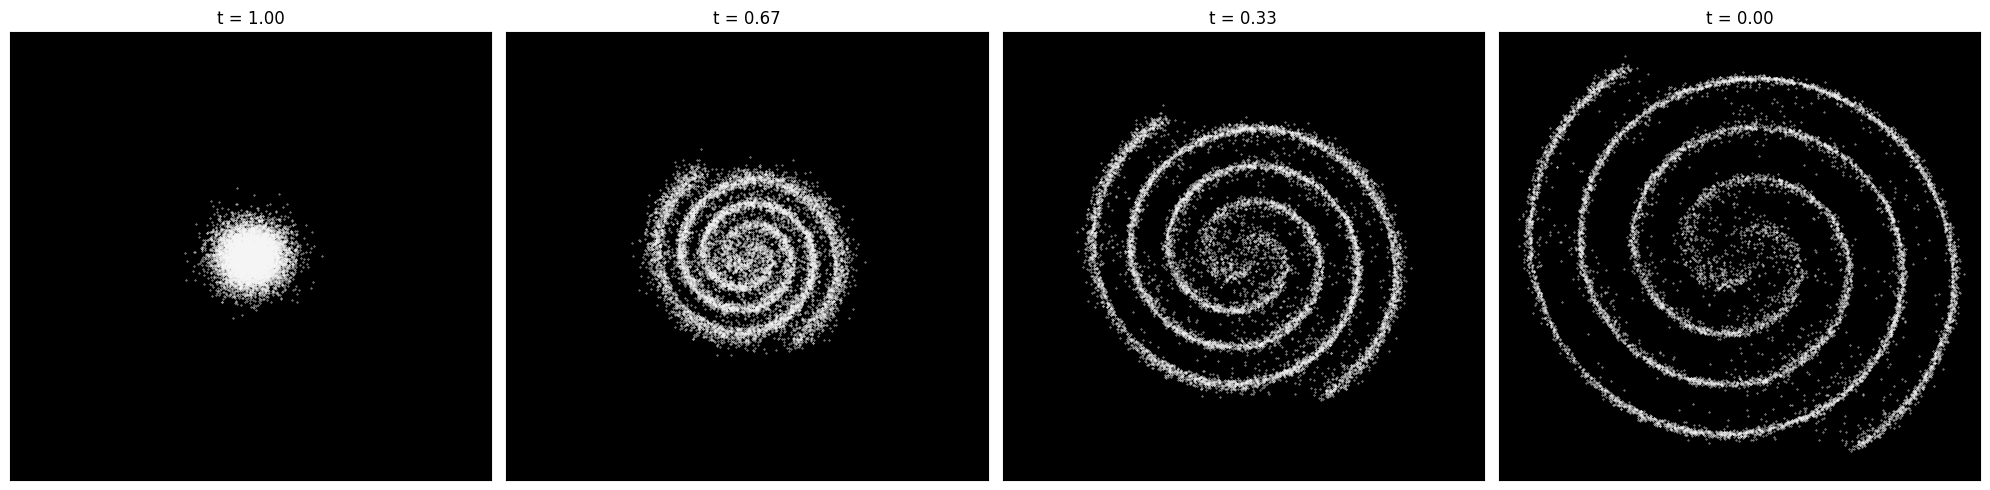

In [337]:
#toy_density_estimation1("spirals/cfm/models/100000_model.pt copy")

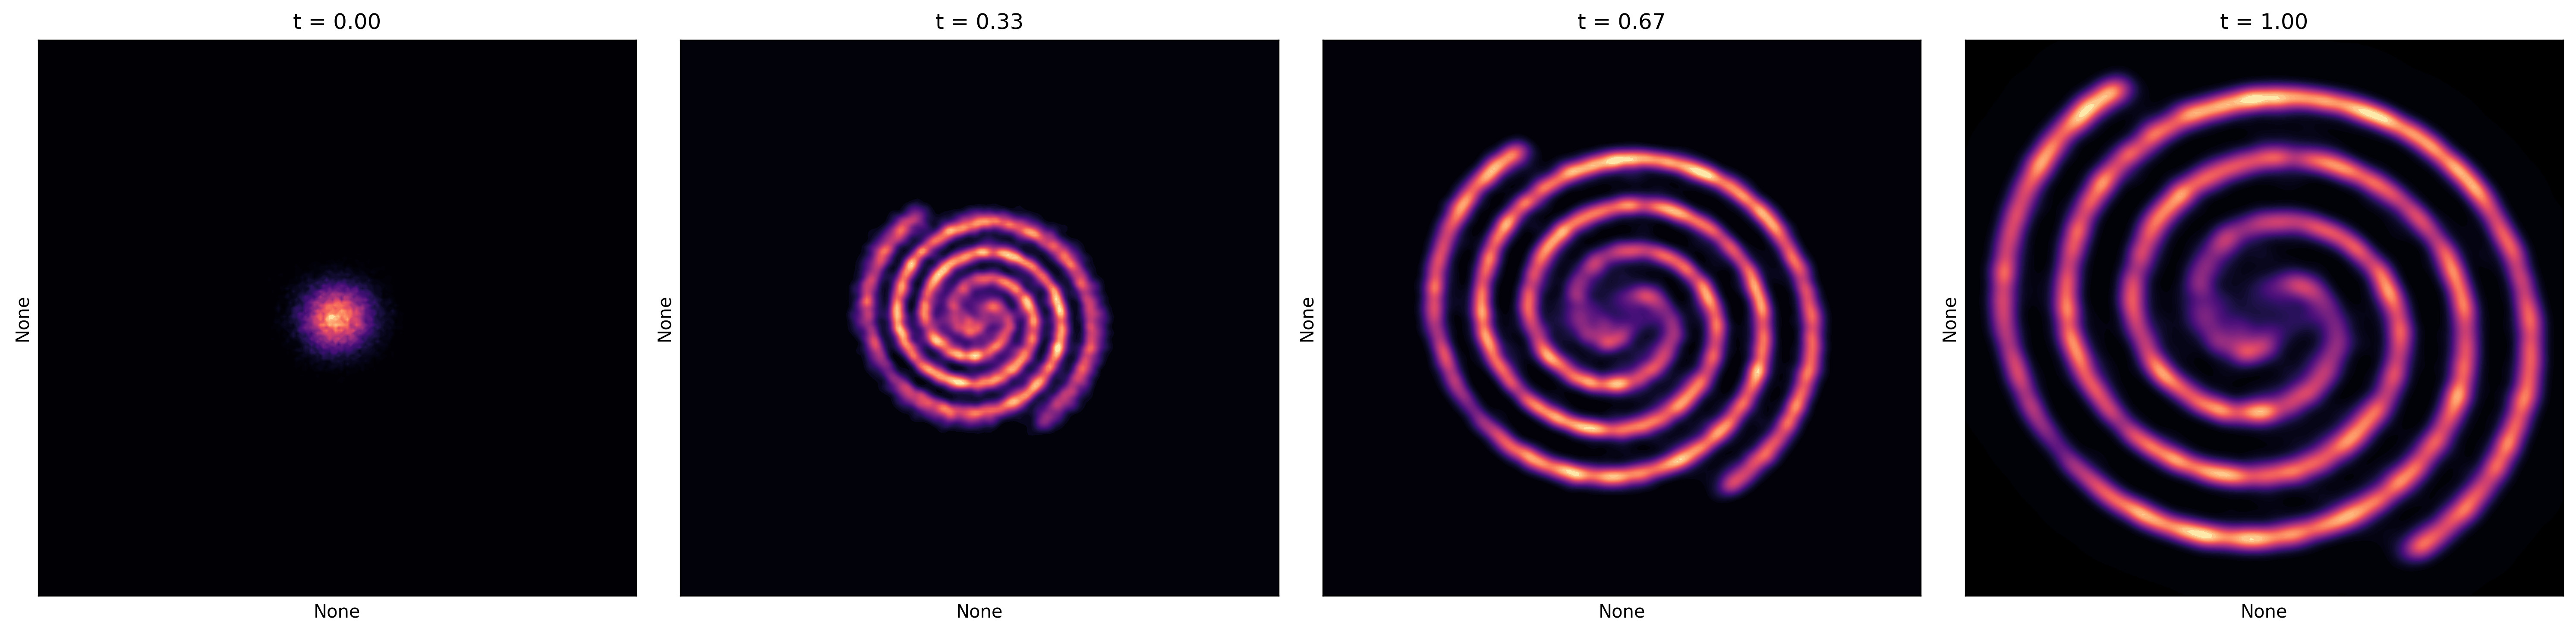

In [335]:
#toy_density_estimation2("spirals/cfm/models/100000_model.pt copy")

In [317]:
#MNIST PLOTS

def generate_grid(model_path: str, seed: int=4):
    dataset, training, _, name = model_path.split('/')
    directory = os.path.join(dataset, training, 'plots')
    os.makedirs(directory, exist_ok=True)

    x, _, odefunc = setup_model_and_data(dataset, seed)
    x = x[0, :25, :, :]

    t=torch.linspace(0,1,2).type(torch.float32)

    odefunc.load_state_dict(torch.load(model_path))
    odefunc.eval()

    cont_NF = NODE(odefunc)
    images = cont_NF(torch.randn((25,1,28,28)), traj=False, t=t).detach().numpy()

    fig, axes = plt.subplots(5, 5, figsize=(10, 10))  
    axes = axes.flatten()  

    for i in range(25):
        ax = axes[i]
        ax.imshow(images[i, 0, :, :], cmap='gray')  
        ax.axis('off')  

    plt.tight_layout()
    plt.savefig(os.path.join(directory, f'{dataset}_grid'))


def plot_mnist_flow(model_path: str, seed: int=4):
    dataset, training, _, name = model_path.split('/')
    directory = os.path.join(dataset, training, 'plots')
    os.makedirs(directory, exist_ok=True)

    x, _, odefunc = setup_model_and_data(dataset, seed)
    x = x[0, :1, :, :]

    t=torch.linspace(0,1,5).type(torch.float32)

    odefunc.load_state_dict(torch.load(model_path))
    odefunc.eval()

    cont_NF = NODE(odefunc)
    flow = cont_NF(x, traj=True, t=t).detach().numpy()
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for i, ax in enumerate(axes):
        ax.imshow(flow[i, 0, 0, :, :], cmap='gray')
        ax.set_title(f't = {t[i]:.2f}')
        ax.axis('off')  

    plt.tight_layout()
    plt.savefig(os.path.join(directory, f'{dataset}_flow'))

In [318]:
#plot_mnist_flow('mnist/cfm/models/3_model.pt')

In [319]:
#generate_grid('mnist/cfm/models/3_model.pt')

In [321]:
"""                          SCRIPTS                      """

'                          SCRIPTS                      '

In [324]:
"""datasets: ['moons', 'gaussians', 'spirals', 'mnist']"""

#script to train with all training methods

train_TOY = False
train_MNIST = False

training_methods = ['cfm', 'rnode', 'node']
odeint_method = 'rk4'

for i in training_methods:
    #function with parameters for TOY dataset
    if train_TOY:
        train_model('gaussians', i, 
                    n_batches=20000, 
                    batch_size=200, 
                    odeint_method=odeint_method)

    #function with parameters for MNIST dataset
    if train_MNIST:
        train_model('mnist', i, 
                    n_epochs=10, 
                    odeint_method=odeint_method)


In [325]:
#script to evaluate all different models w.r.t one dataset
evaluate = False
dataset = 'moons'

if evaluate:
    for i in training_methods:
        print(f"TEST {i} for {dataset}\n")
        evaluate_models(os.path.join(dataset, i, 'models'))

In [ ]:
training_method = 'rnode'
dataset = 'mnist'
odeint_method = 'rk4'

print(f"TRAINING {training_method} for {dataset}\n")
train_model(dataset, training_method, 
            n_batches=100_000, 
            batch_size=256,
            n_epochs=10, 
            odeint_method=odeint_method)

print(f"TEST {training_method} for {dataset}\n")
evaluate_models(os.path.join(dataset, training_method, 'models'))

In [327]:
#script to download a directory

#from google.colab import files
def download_folder(folder_path: str):
    output_path = folder_path + '_backup'
    shutil.make_archive(output_path, 'zip', folder_path)
    #files.download(output_path + '.zip')

#download_folder()